# PROJET D'OPTIMISATION - GRP 4 

## Restauration d'images 

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Question 1

_(Réponses aux questions théoriques)_

### Question 4

[[0.20392157 0.20392157 0.20392157 ... 0.34509804 0.34509804 0.35294118]
 [0.2        0.2        0.20784314 ... 0.34509804 0.34509804 0.35294118]
 [0.19607843 0.20392157 0.21176471 ... 0.35294118 0.35294118 0.36078431]
 ...
 [0.18823529 0.17647059 0.19215686 ... 0.07058824 0.0745098  0.0745098 ]
 [0.18823529 0.17647059 0.19215686 ... 0.0745098  0.0745098  0.0745098 ]
 [0.18431373 0.17647059 0.18823529 ... 0.0745098  0.0745098  0.0745098 ]]


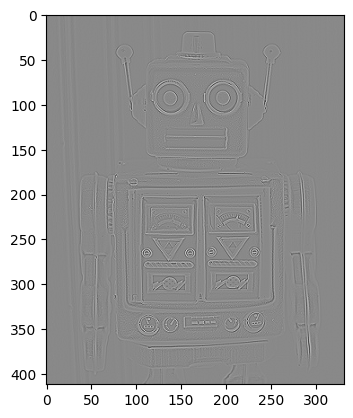

In [47]:
def grad(u):
    """Computes the discrete gradient of a (n x m) matrix."""
    
    (n, m) = u.shape
    grad = np.zeros((n,m,2))

    grad[:n-1,:,0] = u[1:n, :] - u[0:n-1, :]
    grad[:,:m-1,1] = u[:, 1:m] - u[:, 0:m-1]

    return grad

def div(v):
    """Computes the discrete divergence of a vector of size (n x m x 2)."""
    
    (n, m) = v.shape[:2]  # v is a vector of size n x m x 2
    v_x = v[:, :, 0]
    v_y = v[:, :, 1]
    div = np.zeros((n, m))
    
    div[0, :] += v_x[0, :]
    div[n-1, :] += -v_x[n-2, :]
    div[1:n-1, :] += (v_x[1:n-1, :] - v_x[0:n-2, :])
    
    div[:, 0] += v_y[:, 0]
    div[:, m-1] += -v_y[:, m-2]
    div[:, 1:m-1] += (v_y[:, 1:m-1] - v_y[:, 0:m-2])
    
    return div

def display(image):
    # Rescaling values from 0 to 1
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    (n, m) = image.shape[:2]

    # Copying each value to a tuple
    gray_im = np.zeros((n,m,3))
    gray_im[:,:,0] = image
    gray_im[:,:,1] = image
    gray_im[:,:,2] = image

    plt.imshow(gray_im)


u = plt.imread("./robot_no_noise.jpg")
u = u[:,:,0]/255

laplacian = div(grad(u))  
display(laplacian)
print(u)

### Question 5 
_Algorithme de descente de gradient à pas fixe_

### V1 

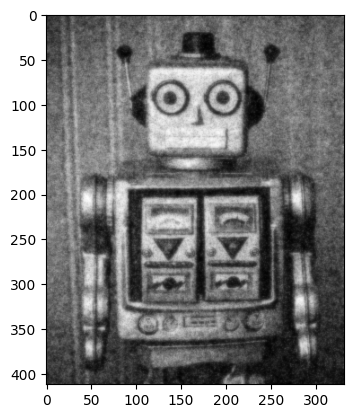

In [76]:
u_b = plt.imread("./robot_noise.jpg")[:,:,0]/255

def grad_f(u: np.ndarray) -> np.ndarray:
    """Returns the gradient of function f at matrix u."""
    return (u - u_b - 2*div(grad(u)))

def grad_descent(z0: np.ndarray, step: float, eps: float=1e-8, n_max: int=100) -> np.ndarray:
    """Implements the gradient descent algorithm with a constant step."""
    z = z0
    n = 0

    while np.linalg.norm(grad_f(z), ord='fro') >= eps and n <= n_max:
        z = z - step * grad_f(z)
    
    return z

# Restoration
u_rest = grad_descent(u_b, step=1e-1)  # Pour l'instant, le pas est choisi au hasard.
                                # => Algorithme pour respecter Wolfe?
display(u_rest)


### V2 

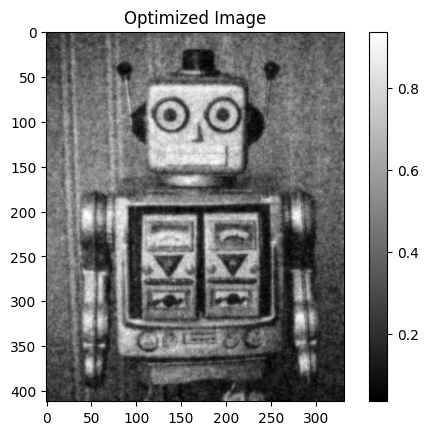

In [77]:
def f(z): 
    return 0.5 * np.sum((z - u)**2) + np.sum(np.linalg.norm(grad(z), axis=2)**2)

def grad_f(z):
    return z - u_b - 2 * div(grad(z))


def optim_gradient_fixed_step(grad_fun, x0, l, max_iter = 100000, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0 
    for k in range(max_iter):
        counter += 1 
        x_k = x_k - l * grad_fun(x_k)
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k)) < epsilon_grad_fun: 
            break
    return x_k, L_x, counter

u_opt = optim_gradient_fixed_step(grad_f, u_b, 0.01, 100, 1e-8)[0]

plt.imshow(u_opt, cmap='gray')
plt.title('Optimized Image')
plt.colorbar()
plt.show()

### Question 6

_Quantification de l'écart_

In [79]:
def RMSE(z: np.ndarray) -> float:
    (n, m) = u.shape
    return (np.sqrt(np.linalg.norm(u - z, ord='fro') / (n * m)))  # Frobenius norm

print(f"RMSE de l'image restaurée V1 : {RMSE(u_rest)}")
print(f"RMSE de l'image restaurée V2 : {RMSE(u_opt)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")

RMSE de l'image restaurée V1 : 0.01615111641021221
RMSE de l'image restaurée V2 : 0.015874216219343543
RMSE de l'image bruitée : 0.02238260721925278


On restaure donc légèrement l'image bruitée, mais c'est encore insatisfaisant.

### Question 7

_Comparaison à la bibliothèque Scipy_

In [80]:
(n, m) = u.shape
u_b2 = u_b.flatten()  # Flattening to a 1D array
u2 = u.flatten()

def f_2(x):
    return 0.5 * np.sum((x - u_b2)**2) + np.sum(np.linalg.norm(grad(x.reshape((n, m))), axis=2)**2)

# Define bounds for each element of u to be between 0 and 1
bounds = [(0, 1) for _ in range(u_b2.size)]

# Using scipy.optimize.minimize with bounds and max iterations
result = scipy.optimize.minimize(
    f_2,
    u_b2,
    method='TNC',
    bounds=bounds
)

u_rest2 = result.x.reshape((n, m))

# Display the restored image
plt.imshow(u_rest2, cmap='gray')
plt.title('Restored Image (Scipy Optimization)')
plt.colorbar()
plt.show()



KeyboardInterrupt: 

## Question 10


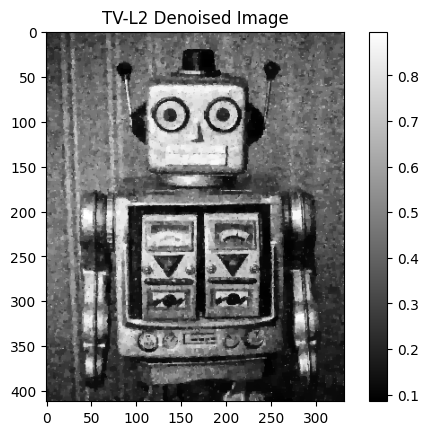

RMSE de l'image restaurée V3 : 0.014764494980389746
RMSE de l'image bruitée : 0.02238260721925278


In [105]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_2(grad_fun, x0, l, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0 
    for k in range(max_iter):
        counter += 1 
        x_k = x_k - l * grad_fun(x_k,x0)
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)) < epsilon_grad_fun: 
            break
    return x_k, L_x, counter

u_opt_3 = optim_gradient_fixed_step_2(subgradient_tv_l2,u_b, 0.0001, 1000, 1e-8)[0]

plt.imshow(u_opt_3, cmap='gray')
plt.title('TV-L2 Denoised Image')
plt.colorbar()
plt.show()
print(f"RMSE de l'image restaurée V3 : {RMSE(u_opt_3)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")


## Question 11

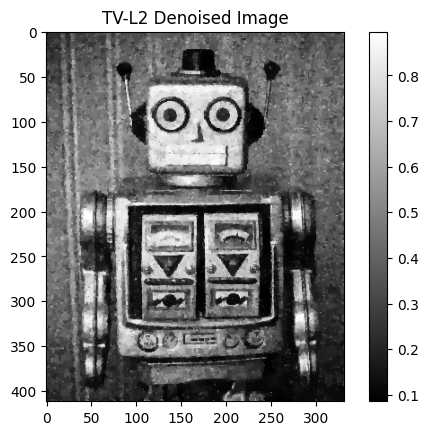

In [ ]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_3(grad_fun, x0, l, beta = 0, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0
    p_k = 0 
    for k in range(max_iter):
        counter += 1 
        p_k = beta * p_k + (1-beta) * (-grad_fun(x_k,x0))
        x_k = x_k + l * p_k
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)) < epsilon_grad_fun: 
            break
        
    return x_k, L_x, counter

u_opt_4 = optim_gradient_fixed_step_3(subgradient_tv_l2,u_b, 0.00001, 0.9, 1000, 1e-8)[0]

plt.imshow(u_opt_4, cmap='gray')
plt.title('TV-L2 Denoised Image')
plt.colorbar()
plt.show()
